In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, ADAM # Rotosolve or rotoselect?
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from sklearn.model_selection import train_test_split

from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_estimator_qnn import CutEstimatorQNN

algorithm_globals.random_seed = 12345

In [2]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

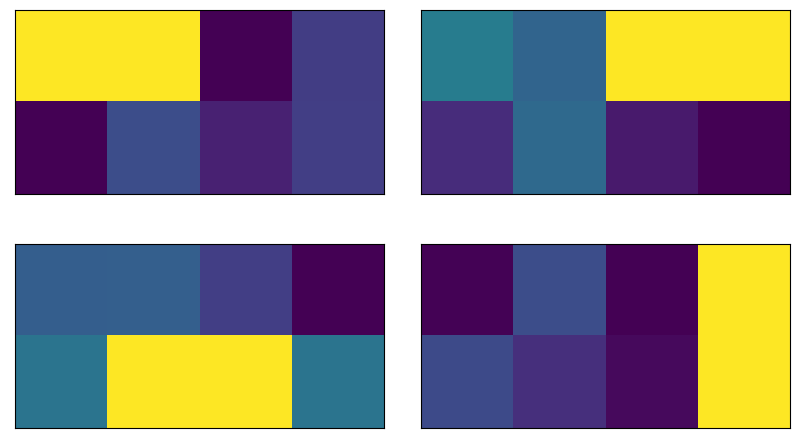

In [3]:

# Generate the dataset
# Goal: decide if the two yellow boxes are horizontal or vertical
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

# Visualize the training images
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)


In [4]:
# Set up the QML circuit
feature_map = ZFeatureMap(8)
phi_vec = ParameterVector('phi', length=8)
 
ansatz = QuantumCircuit(8, name="Ansatz")

for i in range(0, 8):
    ansatz.rx(phi_vec[i], i)
for i in range(0, 7):
    ansatz.cx(i, i+1)
 
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Decompose the ZFeatureMap into individual gates
circuit = circuit.decompose(reps=3)

In [7]:
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])


# Set up the estimator QNN
qnn = CutEstimatorQNN(
    circuit=circuit,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1),  # Set max iterations here
    callback=callback_graph,
    initial_point=np.zeros([8,]),  # Must equal number of parameters
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.0.0 23A344)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 175 rows, 93 columns and 530 nonzeros
Model fingerprint: 0xc2325c01
Variable types: 0 continuous, 93 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 44 rows and 35 columns
Presolve time: 0.00s
Presolved: 131 rows, 58 columns, 399 nonzeros
Variable types: 0 continuous, 58 integer (49 binary)
Found heuristic solution: objective 2.0000000

Root relaxation: objective 2.857143e-01, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

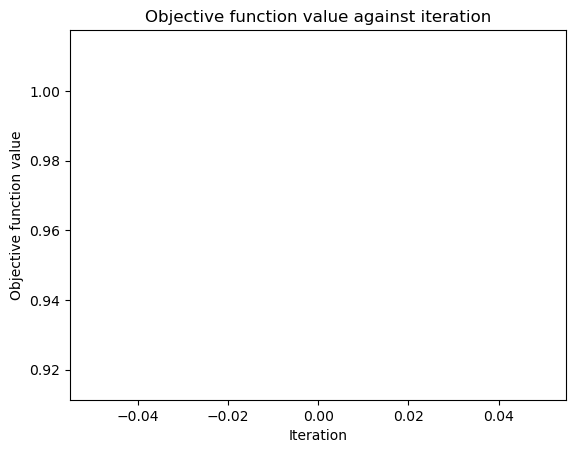

Accuracy from the train data : 58.57%


In [8]:

objective_func_vals = []

x = np.asarray(train_images)
y = np.asarray(train_labels)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
